In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
          
import matplotlib.pyplot as plt
import time

import data_splitter as ds
import data_loader as dl
import run_model as rm
import eval_model as ev

2023-04-12 08:13:22.613187: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-12 08:13:23.915239: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
%load_ext autoreload
%autoreload 2

In [3]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected!')
except Exception: # this command not being found can raise quite a few different errors depending on the configuration
    print('No Nvidia GPU in system!')

Nvidia GPU detected!


In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
KERASTUNER_TUNER_ID="chief"
KERASTUNER_ORACLE_IP="127.0.0.1"
KERASTUNER_ORACLE_PORT="8000"

In [6]:
splitter = ds.DataSplitter(verbose=True)

Total patient_id in training set:  9530
Total patient_id in test set:  2383
Total image_id in training set:  43767
Total image_id in test set:  10939
Total patient_id in training set:  7624
Total patient_id in calibration set:  1906
Total image_id in training set:  35003
Total image_id in calibration set:  8764


In [7]:
# splitter.trainset is the training set in format of {patient_id: [image_id, ...]}
train_ids = splitter.trainset.keys()
label_by_img = splitter.labels

# getting cross-validation folds from training set
RANDOM_STATE = 42
cv_patient, cv_img = splitter.get_cv(n_splits=5, random_state=RANDOM_STATE)

Splitting training set into 5 stratified k-folds...
--Fold:  0
----Total patient_id in training set:  6099
----Total image_id in training set:  28031
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6972
--Fold:  1
----Total patient_id in training set:  6099
----Total image_id in training set:  28016
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6987
--Fold:  2
----Total patient_id in training set:  6099
----Total image_id in training set:  27937
----Total patient_id in validation set:  1525
----Total image_id in validation set:  7066
--Fold:  3
----Total patient_id in training set:  6099
----Total image_id in training set:  28025
----Total patient_id in validation set:  1525
----Total image_id in validation set:  6978
--Fold:  4
----Total patient_id in training set:  6100
----Total image_id in training set:  28003
----Total patient_id in validation set:  1524
----Total image_id in validation set:  7000


In [8]:
metadata = pd.read_csv('train.csv')

## Get 25% sample

In [7]:
# image id of all sample training set after split to calib and train set
train_img_ids = [id for k, v in splitter.trainset.items() for id in v]
print(len(train_img_ids))

35003


In [8]:
print('25% of sample = {} patients, {} images'.format(len(splitter.trainset.keys())*0.25, len(train_img_ids)*0.25))
print('Ratio images : patients = ', len(train_img_ids)/len(splitter.trainset.keys()))

25% of sample = 1906.0 patients, 8750.75 images
Ratio images : patients =  4.591159496327387


In [13]:
# stratified sampling 25% from the training set >> 8,751 images
sample = metadata[metadata['patient_id'].isin(splitter.trainset.keys())]
sample = sample.groupby('cancer', group_keys=False).apply(lambda x: x.sample(frac=0.25))

print(len(sample.patient_id.unique()), len(sample.image_id.unique()))

5529 8751


In [14]:
X = sample.drop(columns='cancer')
y = sample.cancer

X_train, X_validate, y_train, y_validate = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
print(len(X_train), len(X_validate))

7000 1751


In [15]:
sample_train_ids = X_train.image_id.unique()
sample_validate_ids = X_validate.image_id.unique()

# Train from scratch

### Image Resolution 256 x 256

In [9]:
# inception from scratch
IMG_SIZE = (256, 256, 1)

inception = keras.applications.InceptionV3(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # should have exactly 3 inputs channels because it is pre-trained on RBG images
    include_top=False
    )

inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

 batch_normalization_5 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 29, 29, 64)  192         ['conv2d_7[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_10 (BatchN  (None, 29, 29, 96)  288         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_11 (BatchN  (None, 29, 29, 32)  96          ['conv2d_11[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_22 (BatchN  (None, 29, 29, 64)  192         ['conv2d_22[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_22[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_23 (Conv2D)             (None, 29, 29, 96)   55296       ['activation_22[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_2[0][0]']        
                                                                                                  
 conv2d_34 (Conv2D)             (None, 14, 14, 128)  98304       ['mixed3[0][0]']                 
                                                                                                  
 batch_normalization_34 (BatchN  (None, 14, 14, 128)  384        ['conv2d_34[0][0]']              
 ormalizat

                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_44 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_44 (BatchN  (None, 14, 14, 160)  480        ['conv2d_44[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_44 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_44[0][0]'] 
                                                                                                  
 conv2d_45 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_44[0][0]']          
          

 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_54[0][0]'] 
                                                                                                  
 conv2d_55 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_55[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_55 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_55[0][0]'] 
          

                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 192)  576        ['conv2d_65[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_61 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
                                                                                                  
 conv2d_66 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_65[0][0]']          
                                                                                                  
 batch_nor

                                                                                                  
 conv2d_70 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_74 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_70 (BatchN  (None, 14, 14, 192)  576        ['conv2d_70[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_74 (BatchN  (None, 14, 14, 192)  576        ['conv2d_74[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_76 (BatchN  (None, 6, 6, 320)   960         ['conv2d_76[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_78[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_79[0][0]'] 
                                                                                                  
 activation_82 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_82[0][0]'] 
                                                                                                  
 activation_83 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_83[0][0]'] 
          

                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_91[0][0]'] 
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_92[0][0]'] 
                                                                                                  
 batch_normalization_93 (BatchN  (None, 6, 6, 192)   576         ['conv2d_93[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_85 (Activation)     (None, 6, 6, 320)    0           ['batch_normalization_85[0][0]'] 
                                                                                                  
 mixed9_1 

In [36]:
# base_model.summary()
keras.utils.plot_model(inception, show_shapes=True)

In [10]:
train_img_ids = cv_img[0]['train']
val_img_ids = cv_img[0]['validate']

In [20]:
BATCH_SIZE = 4*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [10]:
print(len(train_gen), len(val_gen))

218 54


In [11]:
X, y = train_gen[0]
print(X.shape, y.shape)

(128, 256, 256, 3) (128,)


In [12]:
inception.output.shape[-3:]

TensorShape([6, 6, 2048])

## Out of the box

In [14]:
model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid')
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [15]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder created:  models/inception_rsna_checkpoint/adam
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [16]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = False,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 01:23:49.591831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


218/218 [==============================] - ETA: 0s - loss: 0.1087 - tp: 4.0000 - fp: 124.0000 - tn: 27201.0000 - fn: 575.0000 - accuracy: 0.9749 - precision: 0.0312 - recall: 0.0069 - auc: 0.4965 - prc: 0.0211

2023-04-07 01:47:02.454356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 4.06964, saving model to models/inception_rsna_checkpoint/rsna_adam-lr-default-01-prc0.02-tp0.0-loss4.07.hdf5
218/218 [==============================] - 1490s 7s/step - loss: 0.1087 - tp: 4.0000 - fp: 124.0000 - tn: 27201.0000 - fn: 575.0000 - accuracy: 0.9749 - precision: 0.0312 - recall: 0.0069 - auc: 0.4965 - prc: 0.0211 - val_loss: 4.0696 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.1015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4957 - prc: 0.0203
Epoch 2: val_loss did not improve from 4.06964
218/218 [==============================] - 1486s 7s/step - loss: 0.1015 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27327.0000 - fn: 577.0000 -

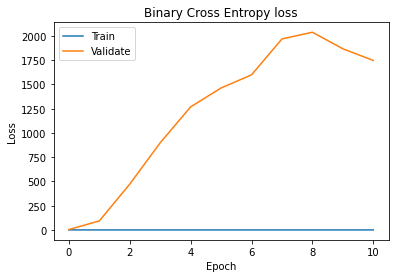

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias

In [11]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
initial_bias = np.log([pos/neg])
print(initial_bias)

[-3.83388407]


In [12]:
initial_bias = tf.keras.initializers.Constant()

model_layers = keras.Sequential([
    keras.layers.Input(inception.output.shape[-3:]),
    keras.layers.GlobalAvgPool2D(),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=initial_bias)
])

model_layers.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [17]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder created:  models/inception_rsna_checkpoint/adam
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [21]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    verbose = 1
    )

stop = time.time()
print('>>> Training time: ', (stop - start))

2023-04-07 06:18:17.617695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 1/100


2023-04-07 06:19:09.384779: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


175/175 [==============================] - ETA: 0s - loss: 0.1059 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27420.0000 - fn: 580.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4837 - prc: 0.0196

2023-04-07 06:23:14.938881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.58195, saving model to models/inception_rsna_checkpoint/rsna_256_bias_adam-lr-default-01-prc0.02-tp0.0-loss0.58.hdf5
175/175 [==============================] - 372s 2s/step - loss: 0.1059 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27420.0000 - fn: 580.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4837 - prc: 0.0196 - val_loss: 0.5820 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6737.0000 - val_fn: 143.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.1017 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27419.0000 - fn: 581.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5267 - prc: 0.0217
Epoch 2: val_loss did not improve from 0.58195
175/175 [==============================] - 280s 1s/step - loss: 0.1017 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27419.

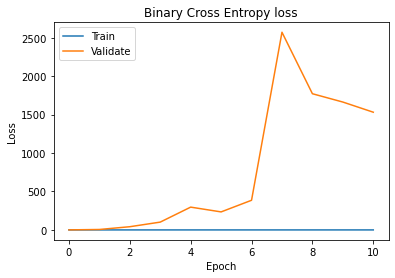

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validate'], loc='upper left')
plt.show()

## Use initial bias and class weight

In [13]:
pos = metadata[metadata.cancer==1].image_id.nunique()
neg = metadata[metadata.cancer==0].image_id.nunique()
total = metadata[metadata.patient_id.isin(splitter.trainset.keys())].image_id.nunique()

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.33
Weight for class 1: 15.11


In [23]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [25]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 07:16:00.874276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


175/175 [==============================] - ETA: 0s - loss: 0.4419 - tp: 240.0000 - fp: 11440.0000 - tn: 15980.0000 - fn: 340.0000 - accuracy: 0.5793 - precision: 0.0205 - recall: 0.4138 - auc: 0.5042 - prc: 0.0210

2023-04-07 07:19:35.682740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1395.68604, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr-default-01-prc0.02-tp0.0-loss1395.69.hdf5
175/175 [==============================] - 305s 2s/step - loss: 0.4419 - tp: 240.0000 - fp: 11440.0000 - tn: 15980.0000 - fn: 340.0000 - accuracy: 0.5793 - precision: 0.0205 - recall: 0.4138 - auc: 0.5042 - prc: 0.0210 - val_loss: 1395.6860 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6736.0000 - val_fn: 144.0000 - val_accuracy: 0.9791 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0209
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.4417 - tp: 278.0000 - fp: 13482.0000 - tn: 13937.0000 - fn: 303.0000 - accuracy: 0.5077 - precision: 0.0202 - recall: 0.4785 - auc: 0.4877 - prc: 0.0202
Epoch 2: val_loss improved from 1395.68604 to 1332.85779, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr-default-02-prc0.02-tp0.0-loss1

Epoch 12/100
175/175 [==============================] - ETA: 0s - loss: 0.4414 - tp: 318.0000 - fp: 15202.0000 - tn: 12218.0000 - fn: 262.0000 - accuracy: 0.4477 - precision: 0.0205 - recall: 0.5483 - auc: 0.4853 - prc: 0.0198
Epoch 12: val_loss did not improve from 1260.63428
175/175 [==============================] - 277s 1s/step - loss: 0.4414 - tp: 318.0000 - fp: 15202.0000 - tn: 12218.0000 - fn: 262.0000 - accuracy: 0.4477 - precision: 0.0205 - recall: 0.5483 - auc: 0.4853 - prc: 0.0198 - val_loss: 1325.9865 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6738.0000 - val_fn: 142.0000 - val_accuracy: 0.9794 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0206
Epoch 13/100
175/175 [==============================] - ETA: 0s - loss: 0.4410 - tp: 275.0000 - fp: 13005.0000 - tn: 14415.0000 - fn: 305.0000 - accuracy: 0.5246 - precision: 0.0207 - recall: 0.4741 - auc: 0.4811 - prc: 0.0194
Epoch 13: val_loss did not improve from 1260.63428
175/175 [=

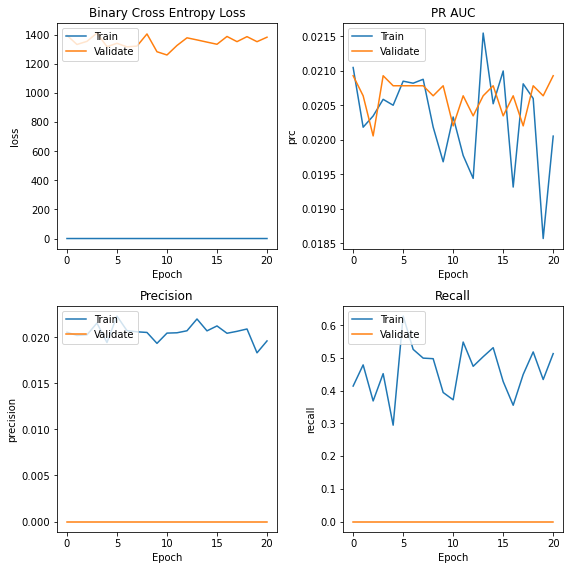

In [28]:
ev.plot_history(history)

### Reducing batch size from 4 x 32 to 1 x 32

In [27]:
BATCH_SIZE = 1*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        n_classes=2,
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [31]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_6 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_5 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [32]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_batch32_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-09 07:29:23.763372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


875/875 [==============================] - ETA: 0s - loss: 66466.1406 - tp: 291.0000 - fp: 13245.0000 - tn: 20943.0000 - fn: 433.0000 - accuracy: 0.6082 - precision: 0.0215 - recall: 0.4019 - auc: 0.5073 - prc: 0.0212

2023-04-09 07:33:50.879291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 67275344.00000, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch32_adam-lr-default-01-prc0.02-tp144.0-loss67275344.00.hdf5
875/875 [==============================] - 351s 381ms/step - loss: 66466.1406 - tp: 291.0000 - fp: 13245.0000 - tn: 20943.0000 - fn: 433.0000 - accuracy: 0.6082 - precision: 0.0215 - recall: 0.4019 - auc: 0.5073 - prc: 0.0212 - val_loss: 67275344.0000 - val_tp: 144.0000 - val_fp: 6800.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0207 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
875/875 [==============================] - ETA: 0s - loss: 57191.0977 - tp: 295.0000 - fp: 13209.0000 - tn: 14211.0000 - fn: 285.0000 - accuracy: 0.5181 - precision: 0.0218 - recall: 0.5086 - auc: 0.5134 - prc: 0.0215
Epoch 2: val_loss improved from 67275344.00000 to 12025944.00000, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch

Epoch 12/100
875/875 [==============================] - ETA: 0s - loss: 53586.9531 - tp: 296.0000 - fp: 13112.0000 - tn: 14308.0000 - fn: 284.0000 - accuracy: 0.5216 - precision: 0.0221 - recall: 0.5103 - auc: 0.5161 - prc: 0.0217
Epoch 12: val_loss improved from 191618.62500 to 167205.95312, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch32_adam-lr-default-12-prc0.02-tp0.0-loss167205.95.hdf5
875/875 [==============================] - 348s 379ms/step - loss: 53586.9531 - tp: 296.0000 - fp: 13112.0000 - tn: 14308.0000 - fn: 284.0000 - accuracy: 0.5216 - precision: 0.0221 - recall: 0.5103 - auc: 0.5161 - prc: 0.0217 - val_loss: 167205.9531 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6801.0000 - val_fn: 143.0000 - val_accuracy: 0.9794 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0206
Epoch 13/100
875/875 [==============================] - ETA: 0s - loss: 47106.9766 - tp: 292.0000 - fp: 13404.0000 - tn: 14015.0000 

Epoch 23/100
875/875 [==============================] - ETA: 0s - loss: 55048.7344 - tp: 291.0000 - fp: 13437.0000 - tn: 13982.0000 - fn: 290.0000 - accuracy: 0.5098 - precision: 0.0212 - recall: 0.5009 - auc: 0.5054 - prc: 0.0211
Epoch 23: val_loss did not improve from 31295.17773
875/875 [==============================] - 352s 383ms/step - loss: 55048.7344 - tp: 291.0000 - fp: 13437.0000 - tn: 13982.0000 - fn: 290.0000 - accuracy: 0.5098 - precision: 0.0212 - recall: 0.5009 - auc: 0.5054 - prc: 0.0211 - val_loss: 1451979.6250 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6800.0000 - val_fn: 144.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 24/100
875/875 [==============================] - ETA: 0s - loss: 58299.2656 - tp: 291.0000 - fp: 13245.0000 - tn: 14175.0000 - fn: 289.0000 - accuracy: 0.5166 - precision: 0.0215 - recall: 0.5017 - auc: 0.5093 - prc: 0.0213
Epoch 24: val_loss did not improve from 31

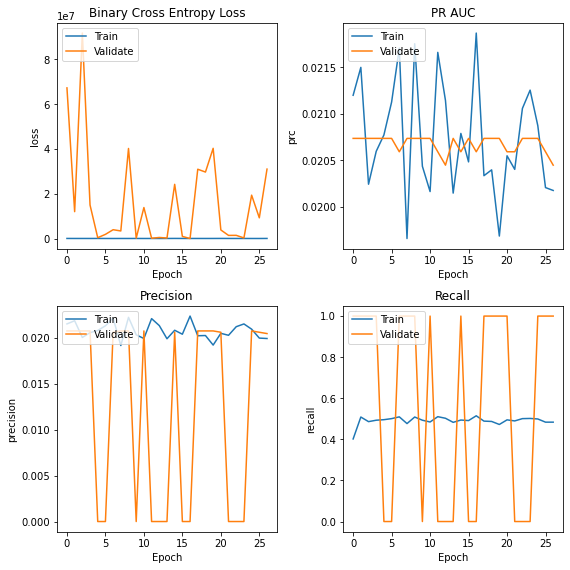

In [33]:
ev.plot_history(history)

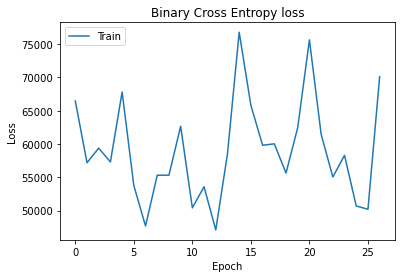

In [35]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Increase batch size from 4 x 32 to 8 x 32

In [16]:
BATCH_SIZE = 8*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [15]:
model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=False,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 2,049
Non-trainable params: 21,802,784
_________________________________________________________________


In [18]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)
CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr-default-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-10 23:20:17.046439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.4414 - tp: 282.0000 - fp: 12774.0000 - tn: 14551.0000 - fn: 297.0000 - accuracy: 0.5316 - precision: 0.0216 - recall: 0.4870 - auc: 0.5127 - prc: 0.0216

2023-04-10 23:27:54.291950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.80827, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr-default-01-prc0.02-tp100.0-loss0.81.hdf5
109/109 [==============================] - 649s 6s/step - loss: 0.4414 - tp: 282.0000 - fp: 12774.0000 - tn: 14551.0000 - fn: 297.0000 - accuracy: 0.5316 - precision: 0.0216 - recall: 0.4870 - auc: 0.5127 - prc: 0.0216 - val_loss: 0.8083 - val_tp: 100.0000 - val_fp: 4684.0000 - val_tn: 2084.0000 - val_fn: 44.0000 - val_accuracy: 0.3160 - val_precision: 0.0209 - val_recall: 0.6944 - val_auc: 0.4805 - val_prc: 0.0213
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4417 - tp: 259.0000 - fp: 11773.0000 - tn: 15555.0000 - fn: 317.0000 - accuracy: 0.5667 - precision: 0.0215 - recall: 0.4497 - auc: 0.4943 - prc: 0.0203
Epoch 2: val_loss improved from 0.80827 to 0.62604, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr-default-02-prc0.02-tp44.0-loss0.63.hd

Epoch 13/100
109/109 [==============================] - ETA: 0s - loss: 0.4427 - tp: 275.0000 - fp: 13037.0000 - tn: 14287.0000 - fn: 305.0000 - accuracy: 0.5219 - precision: 0.0207 - recall: 0.4741 - auc: 0.4980 - prc: 0.0206
Epoch 13: val_loss did not improve from 0.32166
109/109 [==============================] - 447s 4s/step - loss: 0.4427 - tp: 275.0000 - fp: 13037.0000 - tn: 14287.0000 - fn: 305.0000 - accuracy: 0.5219 - precision: 0.0207 - recall: 0.4741 - auc: 0.4980 - prc: 0.0206 - val_loss: 0.3895 - val_tp: 6.0000 - val_fp: 188.0000 - val_tn: 6581.0000 - val_fn: 137.0000 - val_accuracy: 0.9530 - val_precision: 0.0309 - val_recall: 0.0420 - val_auc: 0.4609 - val_prc: 0.0260
Epoch 14/100
109/109 [==============================] - ETA: 0s - loss: 0.4395 - tp: 192.0000 - fp: 10304.0000 - tn: 17028.0000 - fn: 380.0000 - accuracy: 0.6171 - precision: 0.0183 - recall: 0.3357 - auc: 0.4769 - prc: 0.0191
Epoch 14: val_loss did not improve from 0.32166
109/109 [========================

Epoch 25/100
109/109 [==============================] - ETA: 0s - loss: 0.4430 - tp: 235.0000 - fp: 11285.0000 - tn: 16040.0000 - fn: 344.0000 - accuracy: 0.5832 - precision: 0.0204 - recall: 0.4059 - auc: 0.4981 - prc: 0.0206
Epoch 25: val_loss did not improve from 0.22084
109/109 [==============================] - 424s 4s/step - loss: 0.4430 - tp: 235.0000 - fp: 11285.0000 - tn: 16040.0000 - fn: 344.0000 - accuracy: 0.5832 - precision: 0.0204 - recall: 0.4059 - auc: 0.4981 - prc: 0.0206 - val_loss: 0.3449 - val_tp: 3.0000 - val_fp: 82.0000 - val_tn: 6687.0000 - val_fn: 140.0000 - val_accuracy: 0.9679 - val_precision: 0.0353 - val_recall: 0.0210 - val_auc: 0.4593 - val_prc: 0.0258
Epoch 26/100
109/109 [==============================] - ETA: 0s - loss: 0.4465 - tp: 253.0000 - fp: 12547.0000 - tn: 14777.0000 - fn: 327.0000 - accuracy: 0.5386 - precision: 0.0198 - recall: 0.4362 - auc: 0.4748 - prc: 0.0192
Epoch 26: val_loss did not improve from 0.22084
109/109 [=========================

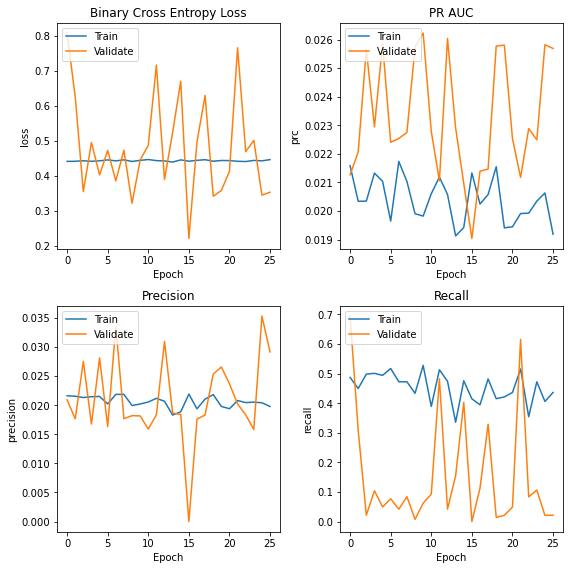

In [19]:
ev.plot_history(history)

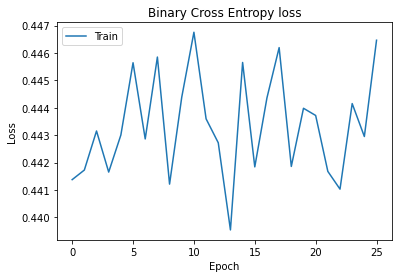

In [20]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

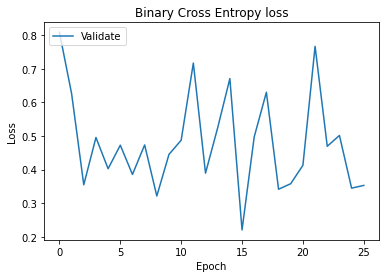

In [21]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validate'], loc='upper left')
plt.show()

### Increase learning rate

In [16]:
LEARNING_RATE = 0.01

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [25]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-2-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-09 01:25:10.961203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
218/218 [==============================] - ETA: 0s - loss: 0.4833 - tp: 287.0000 - fp: 14689.0000 - tn: 12637.0000 - fn: 291.0000 - accuracy: 0.4632 - precision: 0.0192 - recall: 0.4965 - auc: 0.4831 - prc: 0.0197

2023-04-09 01:48:40.927553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 411747.06250, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-2-01-prc0.02-tp0.0-loss411747.06.hdf5
218/218 [==============================] - 1504s 7s/step - loss: 0.4833 - tp: 287.0000 - fp: 14689.0000 - tn: 12637.0000 - fn: 291.0000 - accuracy: 0.4632 - precision: 0.0192 - recall: 0.4965 - auc: 0.4831 - prc: 0.0197 - val_loss: 411747.0625 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6768.0000 - val_fn: 144.0000 - val_accuracy: 0.9792 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4501 - tp: 275.0000 - fp: 12525.0000 - tn: 14798.0000 - fn: 306.0000 - accuracy: 0.5402 - precision: 0.0215 - recall: 0.4733 - auc: 0.4952 - prc: 0.0208
Epoch 2: val_loss did not improve from 411747.06250
218/218 [==============================] - 1502s 7s/step - loss: 0.4501 - tp: 275.0000 - fp: 12525.0000 - tn: 14

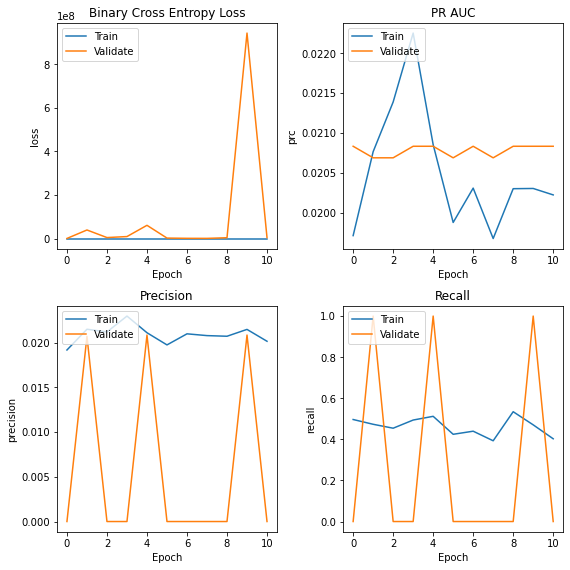

In [26]:
ev.plot_history(history)

### Decrease learning rate

In [29]:
LEARNING_RATE = 0.00001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [30]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-5-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-07 09:15:44.780440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


175/175 [==============================] - ETA: 0s - loss: 0.7250 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34156.0000 - fn: 724.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5005 - prc: 0.0208

2023-04-07 09:19:53.806946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 1911.17676, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-5-01-prc0.02-tp0.0-loss1911.18.hdf5
175/175 [==============================] - 352s 2s/step - loss: 0.7250 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 34156.0000 - fn: 724.0000 - accuracy: 0.9792 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5005 - prc: 0.0208 - val_loss: 1911.1768 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6736.0000 - val_fn: 144.0000 - val_accuracy: 0.9791 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0209
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.4627 - tp: 12.0000 - fp: 628.0000 - tn: 26792.0000 - fn: 568.0000 - accuracy: 0.9573 - precision: 0.0188 - recall: 0.0207 - auc: 0.4798 - prc: 0.0197
Epoch 2: val_loss did not improve from 1911.17676
175/175 [==============================] - 317s 2s/step - loss: 0.4627 - tp: 12.0000 - fp: 628.0000 - tn: 26792.00

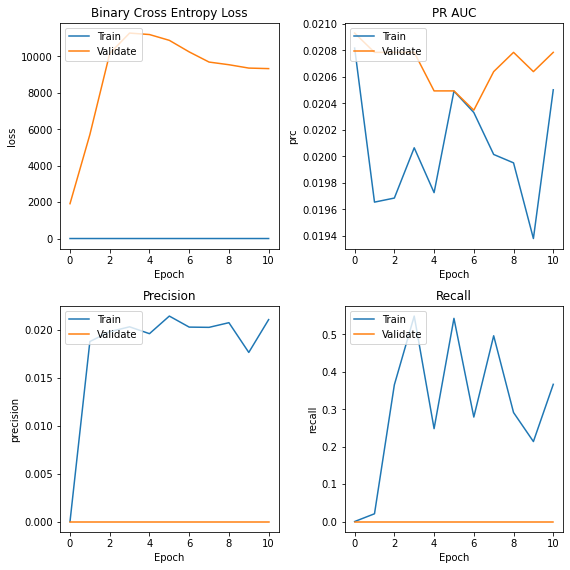

In [31]:
ev.plot_history(history)

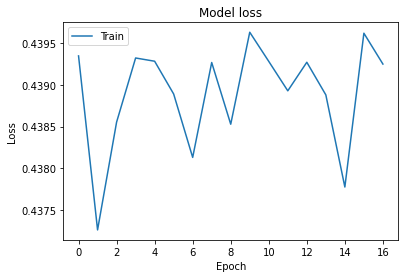

In [32]:
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

### Decreasing learning rate to 1e-6 and increase batch size from 4 x 32 to 8 x 32

In [14]:
BATCH_SIZE = 8*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,

        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [17]:
LEARNING_RATE = 0.000001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder created:  models/inception_rsna_checkpoint/adam
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [24]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr1e-6-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start)) 

Epoch 1/100


2023-04-11 03:40:36.734146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


109/109 [==============================] - ETA: 0s - loss: 0.5020 - tp: 3.0000 - fp: 100.0000 - tn: 33994.0000 - fn: 719.0000 - accuracy: 0.9765 - precision: 0.0291 - recall: 0.0042 - auc: 0.4826 - prc: 0.0209 

2023-04-11 04:04:52.290771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 3.12051, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr1e-6-01-prc0.02-tp144.0-loss3.12.hdf5
109/109 [==============================] - 1577s 14s/step - loss: 0.5020 - tp: 3.0000 - fp: 100.0000 - tn: 33994.0000 - fn: 719.0000 - accuracy: 0.9765 - precision: 0.0291 - recall: 0.0042 - auc: 0.4826 - prc: 0.0209 - val_loss: 3.1205 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.3983 - val_prc: 0.0158
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4707 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.0000 - fn: 578.0000 - accuracy: 0.9793 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4987 - prc: 0.0210 
Epoch 2: val_loss did not improve from 3.12051
109/109 [==============================] - 1587s 14s/step - loss: 0.4707 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 27326.00

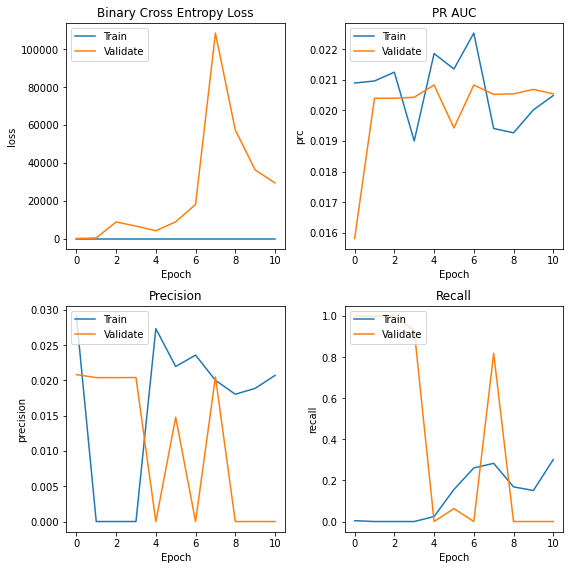

In [25]:
ev.plot_history(history)

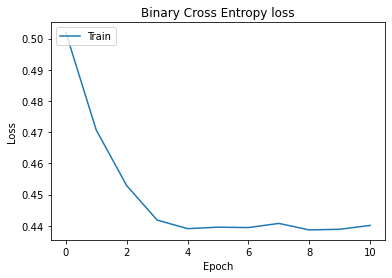

In [26]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

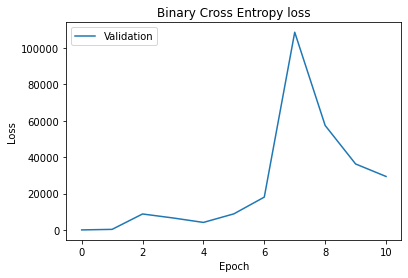

In [27]:
plt.plot(history.history['val_loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

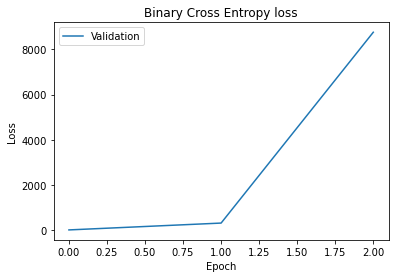

In [32]:
plt.plot(history.history['val_loss'][:3])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

### Freeze and save weights from epoch 1 which has the lowest validation loss for predictions

In [18]:
model.load_weights('../predictive_models/inception_rsna_checkpoint/selected_models/rsna_256_bias_weights_batch256_adam-lr1e-6-01-prc0.02-tp144.0-loss3.12.hdf5')

model.trainable = False
model.save('../predictive_models/inception_imagenet_checkpoint/selected_models/rsna_256_batch256_adam_lr1e-6_epoch1_frozen.hdf5')

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 0
Non-trainable params: 21,804,833
_________________________________________________________________


### Increase learning rate to 1e-4

In [36]:
LEARNING_RATE = 0.0001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential_5 (Sequential)   (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

Epoch 1/100


2023-04-09 10:50:09.753456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


875/875 [==============================] - ETA: 0s - loss: 0.4389 - tp: 700.0000 - fp: 33316.0000 - tn: 906.0000 - fn: 22.0000 - accuracy: 0.0460 - precision: 0.0206 - recall: 0.9695 - auc: 0.4951 - prc: 0.0204

2023-04-09 11:12:42.472010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2445888.50000, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4-01-prc0.02-tp0.0-loss2445888.50.hdf5
875/875 [==============================] - 1445s 2s/step - loss: 0.4389 - tp: 700.0000 - fp: 33316.0000 - tn: 906.0000 - fn: 22.0000 - accuracy: 0.0460 - precision: 0.0206 - recall: 0.9695 - auc: 0.4951 - prc: 0.0204 - val_loss: 2445888.5000 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6801.0000 - val_fn: 143.0000 - val_accuracy: 0.9794 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0206
Epoch 2/100
875/875 [==============================] - ETA: 0s - loss: 0.4393 - tp: 16.0000 - fp: 976.0000 - tn: 26443.0000 - fn: 565.0000 - accuracy: 0.9450 - precision: 0.0161 - recall: 0.0275 - auc: 0.4831 - prc: 0.0200
Epoch 2: val_loss did not improve from 2445888.50000
875/875 [==============================] - 1441s 2s/step - loss: 0.4393 - tp: 16.0000 - fp: 976.0000 - tn: 26443.0

In [21]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4-{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[early_stopping, checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-07 23:33:01.841422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
218/218 [==============================] - ETA: 0s - loss: 0.4411 - tp: 298.0000 - fp: 13270.0000 - tn: 14058.0000 - fn: 278.0000 - accuracy: 0.5145 - precision: 0.0220 - recall: 0.5174 - auc: 0.5183 - prc: 0.0213

2023-04-07 23:40:45.104193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 2.93350, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4-01-prc0.02-tp0.0-loss2.93.hdf5
218/218 [==============================] - 555s 2s/step - loss: 0.4411 - tp: 298.0000 - fp: 13270.0000 - tn: 14058.0000 - fn: 278.0000 - accuracy: 0.5145 - precision: 0.0220 - recall: 0.5174 - auc: 0.5183 - prc: 0.0213 - val_loss: 2.9335 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6769.0000 - val_fn: 143.0000 - val_accuracy: 0.9793 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0207
Epoch 2/100
218/218 [==============================] - ETA: 0s - loss: 0.4443 - tp: 261.0000 - fp: 12155.0000 - tn: 15171.0000 - fn: 317.0000 - accuracy: 0.5530 - precision: 0.0210 - recall: 0.4516 - auc: 0.5012 - prc: 0.0210
Epoch 2: val_loss did not improve from 2.93350
218/218 [==============================] - 564s 2s/step - loss: 0.4443 - tp: 261.0000 - fp: 12155.0000 - tn: 15171.0000 - fn: 317.000

Process Keras_worker_ForkPoolWorker-1338:
Process Keras_worker_ForkPoolWorker-1333:
Process Keras_worker_ForkPoolWorker-1324:
Process Keras_worker_ForkPoolWorker-1340:
Process Keras_worker_ForkPoolWorker-1317:
Process Keras_worker_ForkPoolWorker-1329:
Process Keras_worker_ForkPoolWorker-1337:
Process Keras_worker_ForkPoolWorker-1330:
Process Keras_worker_ForkPoolWorker-1331:
Process Keras_worker_ForkPoolWorker-1314:
Process Keras_worker_ForkPoolWorker-1334:
Process Keras_worker_ForkPoolWorker-1332:
Process Keras_worker_ForkPoolWorker-1336:
Process Keras_worker_ForkPoolWorker-1313:
Process Keras_worker_ForkPoolWorker-1326:
Process Keras_worker_ForkPoolWorker-1342:
Process Keras_worker_ForkPoolWorker-1335:
Process Keras_worker_ForkPoolWorker-1339:
Process Keras_worker_ForkPoolWorker-1344:
Process Keras_worker_ForkPoolWorker-1328:
Process Keras_worker_ForkPoolWorker-1316:
Process Keras_worker_ForkPoolWorker-1318:
Process Keras_worker_ForkPoolWorker-1315:
Process Keras_worker_ForkPoolWorke

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108,

  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/process.py", line 108, 

KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
  File "/sw/pkgs/arc/python3.9-anaconda/2021.11/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt
KeyboardInterrupt


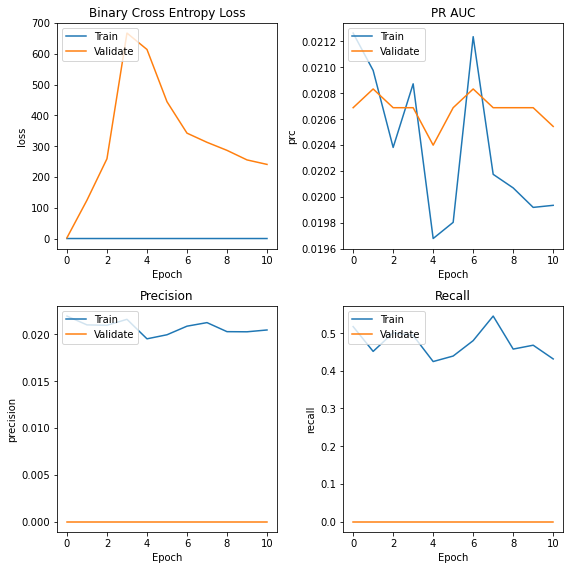

In [22]:
ev.plot_history(history)

### No early stopping

In [19]:
LEARNING_RATE = 0.0001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [23]:
start = time.time()

EPOCH = 100

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4_no_earlystop_{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint],
    use_multiprocessing = True,
    workers = 40,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-08 04:06:04.658643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100


2023-04-08 04:06:33.219226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8700


175/175 [==============================] - ETA: 0s - loss: 0.4450 - tp: 250.0000 - fp: 12550.0000 - tn: 14871.0000 - fn: 329.0000 - accuracy: 0.5400 - precision: 0.0195 - recall: 0.4318 - auc: 0.4863 - prc: 0.0195

2023-04-08 04:10:13.542955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 0.58305, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4_no_earlystop_01-prc0.02-tp36.0-loss0.58.hdf5
175/175 [==============================] - 342s 2s/step - loss: 0.4450 - tp: 250.0000 - fp: 12550.0000 - tn: 14871.0000 - fn: 329.0000 - accuracy: 0.5400 - precision: 0.0195 - recall: 0.4318 - auc: 0.4863 - prc: 0.0195 - val_loss: 0.5830 - val_tp: 36.0000 - val_fp: 1615.0000 - val_tn: 5121.0000 - val_fn: 108.0000 - val_accuracy: 0.7496 - val_precision: 0.0218 - val_recall: 0.2500 - val_auc: 0.4870 - val_prc: 0.0199
Epoch 2/100
175/175 [==============================] - ETA: 0s - loss: 0.4448 - tp: 256.0000 - fp: 13024.0000 - tn: 14395.0000 - fn: 325.0000 - accuracy: 0.5232 - precision: 0.0193 - recall: 0.4406 - auc: 0.4765 - prc: 0.0194
Epoch 2: val_loss did not improve from 0.58305
175/175 [==============================] - 352s 2s/step - loss: 0.4448 - tp: 256.0000 - fp: 13024.0000 - tn: 14395.0000 - fn: 325.0

Epoch 13/100
175/175 [==============================] - ETA: 0s - loss: 0.4415 - tp: 294.0000 - fp: 14746.0000 - tn: 12673.0000 - fn: 287.0000 - accuracy: 0.4631 - precision: 0.0195 - recall: 0.5060 - auc: 0.4859 - prc: 0.0198
Epoch 13: val_loss did not improve from 0.58305
175/175 [==============================] - 309s 2s/step - loss: 0.4415 - tp: 294.0000 - fp: 14746.0000 - tn: 12673.0000 - fn: 287.0000 - accuracy: 0.4631 - precision: 0.0195 - recall: 0.5060 - auc: 0.4859 - prc: 0.0198 - val_loss: 9109.8555 - val_tp: 131.0000 - val_fp: 6362.0000 - val_tn: 375.0000 - val_fn: 12.0000 - val_accuracy: 0.0735 - val_precision: 0.0202 - val_recall: 0.9161 - val_auc: 0.4859 - val_prc: 0.0202
Epoch 14/100
175/175 [==============================] - ETA: 0s - loss: 0.4396 - tp: 195.0000 - fp: 9245.0000 - tn: 18176.0000 - fn: 384.0000 - accuracy: 0.6561 - precision: 0.0207 - recall: 0.3368 - auc: 0.4949 - prc: 0.0205
Epoch 14: val_loss did not improve from 0.58305
175/175 [=====================

Epoch 25/100
175/175 [==============================] - ETA: 0s - loss: 0.4398 - tp: 289.0000 - fp: 11871.0000 - tn: 15548.0000 - fn: 292.0000 - accuracy: 0.5656 - precision: 0.0238 - recall: 0.4974 - auc: 0.5268 - prc: 0.0229
Epoch 25: val_loss did not improve from 0.58305
175/175 [==============================] - 306s 2s/step - loss: 0.4398 - tp: 289.0000 - fp: 11871.0000 - tn: 15548.0000 - fn: 292.0000 - accuracy: 0.5656 - precision: 0.0238 - recall: 0.4974 - auc: 0.5268 - prc: 0.0229 - val_loss: 16655.9434 - val_tp: 144.0000 - val_fp: 6736.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0209 - val_precision: 0.0209 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0209
Epoch 26/100
175/175 [==============================] - ETA: 0s - loss: 0.4406 - tp: 266.0000 - fp: 13174.0000 - tn: 14245.0000 - fn: 315.0000 - accuracy: 0.5182 - precision: 0.0198 - recall: 0.4578 - auc: 0.4824 - prc: 0.0198
Epoch 26: val_loss did not improve from 0.58305
175/175 [==============

Epoch 37/100
175/175 [==============================] - ETA: 0s - loss: 0.4405 - tp: 241.0000 - fp: 11759.0000 - tn: 15661.0000 - fn: 339.0000 - accuracy: 0.5679 - precision: 0.0201 - recall: 0.4155 - auc: 0.4931 - prc: 0.0202
Epoch 37: val_loss did not improve from 0.58305
175/175 [==============================] - 252s 1s/step - loss: 0.4405 - tp: 241.0000 - fp: 11759.0000 - tn: 15661.0000 - fn: 339.0000 - accuracy: 0.5679 - precision: 0.0201 - recall: 0.4155 - auc: 0.4931 - prc: 0.0202 - val_loss: 2537.8005 - val_tp: 142.0000 - val_fp: 6734.0000 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.0212 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5003 - val_prc: 0.0207
Epoch 38/100
175/175 [==============================] - ETA: 0s - loss: 0.4398 - tp: 260.0000 - fp: 12380.0000 - tn: 15040.0000 - fn: 320.0000 - accuracy: 0.5464 - precision: 0.0206 - recall: 0.4483 - auc: 0.4969 - prc: 0.0199
Epoch 38: val_loss did not improve from 0.58305
175/175 [===================

Epoch 49/100
175/175 [==============================] - ETA: 0s - loss: 0.4399 - tp: 191.0000 - fp: 8449.0000 - tn: 18970.0000 - fn: 390.0000 - accuracy: 0.6843 - precision: 0.0221 - recall: 0.3287 - auc: 0.4950 - prc: 0.0206
Epoch 49: val_loss did not improve from 0.58305
175/175 [==============================] - 255s 1s/step - loss: 0.4399 - tp: 191.0000 - fp: 8449.0000 - tn: 18970.0000 - fn: 390.0000 - accuracy: 0.6843 - precision: 0.0221 - recall: 0.3287 - auc: 0.4950 - prc: 0.0206 - val_loss: 3638.3904 - val_tp: 143.0000 - val_fp: 6737.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 50/100
175/175 [==============================] - ETA: 0s - loss: 0.4404 - tp: 260.0000 - fp: 12060.0000 - tn: 15359.0000 - fn: 321.0000 - accuracy: 0.5578 - precision: 0.0211 - recall: 0.4475 - auc: 0.5036 - prc: 0.0209
Epoch 50: val_loss did not improve from 0.58305
175/175 [=================

Epoch 61/100
175/175 [==============================] - ETA: 0s - loss: 0.4394 - tp: 215.0000 - fp: 10345.0000 - tn: 17075.0000 - fn: 365.0000 - accuracy: 0.6175 - precision: 0.0204 - recall: 0.3707 - auc: 0.4984 - prc: 0.0204
Epoch 61: val_loss did not improve from 0.58305
175/175 [==============================] - 277s 2s/step - loss: 0.4394 - tp: 215.0000 - fp: 10345.0000 - tn: 17075.0000 - fn: 365.0000 - accuracy: 0.6175 - precision: 0.0204 - recall: 0.3707 - auc: 0.4984 - prc: 0.0204 - val_loss: 548.8109 - val_tp: 71.0000 - val_fp: 2331.0000 - val_tn: 4405.0000 - val_fn: 73.0000 - val_accuracy: 0.6506 - val_precision: 0.0296 - val_recall: 0.4931 - val_auc: 0.5734 - val_prc: 0.0266
Epoch 62/100
175/175 [==============================] - ETA: 0s - loss: 0.4395 - tp: 246.0000 - fp: 11754.0000 - tn: 15666.0000 - fn: 334.0000 - accuracy: 0.5683 - precision: 0.0205 - recall: 0.4241 - auc: 0.4999 - prc: 0.0208
Epoch 62: val_loss did not improve from 0.58305
175/175 [=====================

Epoch 73/100
175/175 [==============================] - ETA: 0s - loss: 0.4393 - tp: 259.0000 - fp: 12381.0000 - tn: 15040.0000 - fn: 320.0000 - accuracy: 0.5464 - precision: 0.0205 - recall: 0.4473 - auc: 0.4902 - prc: 0.0197
Epoch 73: val_loss did not improve from 0.58305
175/175 [==============================] - 327s 2s/step - loss: 0.4393 - tp: 259.0000 - fp: 12381.0000 - tn: 15040.0000 - fn: 320.0000 - accuracy: 0.5464 - precision: 0.0205 - recall: 0.4473 - auc: 0.4902 - prc: 0.0197 - val_loss: 442.6870 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6738.0000 - val_fn: 142.0000 - val_accuracy: 0.9794 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0206
Epoch 74/100
175/175 [==============================] - ETA: 0s - loss: 0.4397 - tp: 202.0000 - fp: 10198.0000 - tn: 17222.0000 - fn: 378.0000 - accuracy: 0.6223 - precision: 0.0194 - recall: 0.3483 - auc: 0.4869 - prc: 0.0193
Epoch 74: val_loss did not improve from 0.58305
175/175 [========

Epoch 85/100
175/175 [==============================] - ETA: 0s - loss: 0.4399 - tp: 418.0000 - fp: 19742.0000 - tn: 7678.0000 - fn: 162.0000 - accuracy: 0.2891 - precision: 0.0207 - recall: 0.7207 - auc: 0.4895 - prc: 0.0200
Epoch 85: val_loss did not improve from 0.58305
175/175 [==============================] - 312s 2s/step - loss: 0.4399 - tp: 418.0000 - fp: 19742.0000 - tn: 7678.0000 - fn: 162.0000 - accuracy: 0.2891 - precision: 0.0207 - recall: 0.7207 - auc: 0.4895 - prc: 0.0200 - val_loss: 328.9729 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 6736.0000 - val_fn: 144.0000 - val_accuracy: 0.9791 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_prc: 0.0209
Epoch 86/100
175/175 [==============================] - ETA: 0s - loss: 0.4401 - tp: 245.0000 - fp: 11755.0000 - tn: 15667.0000 - fn: 333.0000 - accuracy: 0.5683 - precision: 0.0204 - recall: 0.4239 - auc: 0.4821 - prc: 0.0196
Epoch 86: val_loss did not improve from 0.58305
175/175 [==========

Epoch 97/100
175/175 [==============================] - ETA: 0s - loss: 0.4406 - tp: 175.0000 - fp: 8785.0000 - tn: 18634.0000 - fn: 406.0000 - accuracy: 0.6718 - precision: 0.0195 - recall: 0.3012 - auc: 0.4854 - prc: 0.0200
Epoch 97: val_loss did not improve from 0.58305
175/175 [==============================] - 385s 2s/step - loss: 0.4406 - tp: 175.0000 - fp: 8785.0000 - tn: 18634.0000 - fn: 406.0000 - accuracy: 0.6718 - precision: 0.0195 - recall: 0.3012 - auc: 0.4854 - prc: 0.0200 - val_loss: 33.7551 - val_tp: 138.0000 - val_fp: 6470.0000 - val_tn: 268.0000 - val_fn: 4.0000 - val_accuracy: 0.0590 - val_precision: 0.0209 - val_recall: 0.9718 - val_auc: 0.5043 - val_prc: 0.0208
Epoch 98/100
175/175 [==============================] - ETA: 0s - loss: 0.4393 - tp: 303.0000 - fp: 15377.0000 - tn: 12043.0000 - fn: 277.0000 - accuracy: 0.4409 - precision: 0.0193 - recall: 0.5224 - auc: 0.4878 - prc: 0.0196
Epoch 98: val_loss did not improve from 0.58305
175/175 [=========================

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


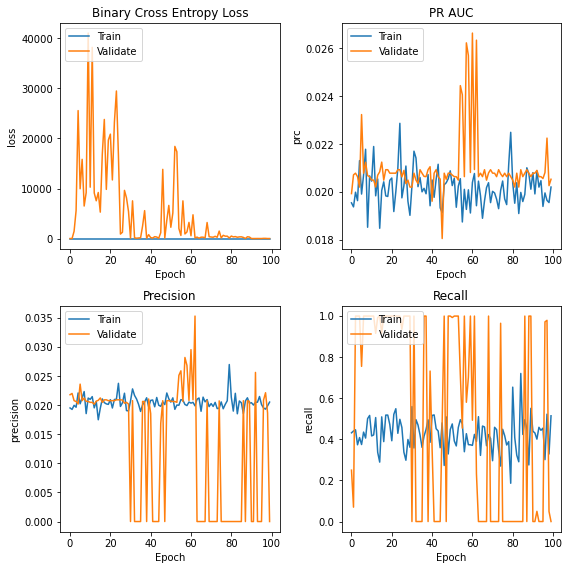

In [24]:
ev.plot_history(history)

In [26]:
model.save('../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_adam-lr1e-4_no_earlystop_100--prc0.02-tp01-loss1.88.hdf5')

### Increase batch size from 4 x 32 to 8 x 32

In [14]:
BATCH_SIZE = 8*32
IMG_SIZE = (256, 256, 1)
RANDOM_STATE = 42 # the random state that used to create cv splits

BASEPATH = '' # directory containing the preprocess images of training set

train_gen, val_gen = rm.get_train_val_generators(
        train_img_ids,
        val_img_ids,
        label_img_dict = splitter.labels,
        patient_img_dict = splitter.trainset,
    
        from_numpy=True,
        basepath=BASEPATH,
        batch_size=BATCH_SIZE,
        img_size=IMG_SIZE,
    
        shuffle=True,
        normalize=(0, 1),
        feature_extractor='CNN',
        CNN_preprocess = keras.applications.inception_v3.preprocess_input
        )

In [15]:
LEARNING_RATE = 0.0001

model = rm.make_or_restore_model(
    model_layers,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1]),
    augment_layers=True,
    base_model=inception,
    trainable=True,
    loss_func = keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=METRICS,
    checkpoint_path='../predictive_models/inception_rsna_checkpoint/adam'
)

model.summary()

Checkpoint path:  models/inception_rsna_checkpoint/adam
---Checkpoint folder already exists
Creating a new model...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 sequential (Sequential)     (None, 1)                 2049      
                                                                 
Total params: 21,804,833
Trainable params: 21,770,401
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
start = time.time()

EPOCH = 100

early_stopping = tf.keras.callbacks.EarlyStopping('val_loss', patience=10)

CHECKPOINT_PATH = '../predictive_models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr1e-4_{epoch:02d}-prc{val_prc:.2f}-tp{val_tp}-loss{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath = CHECKPOINT_PATH,
    save_weights_only = True,
    monitor = 'val_loss',
    mode = 'min',
    save_best_only = True,
    save_freq = 'epoch',
    verbose = 1
)

history = model.fit(
    train_gen,
    epochs=EPOCH,
    callbacks=[checkpoint],
    use_multiprocessing = True,
    workers = 32,
    validation_data=val_gen,
    class_weight=class_weight,
    verbose = 1
    )


stop = time.time()
print('>>> Training time: ', (stop - start))  

2023-04-10 01:28:06.370540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype float and shape [2]
	 [[{{node Placeholder/_3}}]]


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 0.4432 - tp: 224.0000 - fp: 12576.0000 - tn: 14750.0000 - fn: 354.0000 - accuracy: 0.5366 - precision: 0.0175 - recall: 0.3875 - auc: 0.4667 - prc: 0.0186 

2023-04-10 01:52:12.813029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]



Epoch 1: val_loss improved from inf to 3.50037, saving model to models/inception_rsna_checkpoint/rsna_256_bias_weights_batch256_adam-lr1e-4_01-prc0.02-tp143.0-loss3.50.hdf5
109/109 [==============================] - 1571s 14s/step - loss: 0.4432 - tp: 224.0000 - fp: 12576.0000 - tn: 14750.0000 - fn: 354.0000 - accuracy: 0.5366 - precision: 0.0175 - recall: 0.3875 - auc: 0.4667 - prc: 0.0186 - val_loss: 3.5004 - val_tp: 143.0000 - val_fp: 6769.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0207 - val_precision: 0.0207 - val_recall: 1.0000 - val_auc: 0.5176 - val_prc: 0.0222
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 0.4444 - tp: 220.0000 - fp: 11556.0000 - tn: 15768.0000 - fn: 360.0000 - accuracy: 0.5730 - precision: 0.0187 - recall: 0.3793 - auc: 0.4752 - prc: 0.0195 
Epoch 2: val_loss did not improve from 3.50037
109/109 [==============================] - 1573s 14s/step - loss: 0.4444 - tp: 220.0000 - fp: 11556.0000 - tn: 15768.0000 - fn:

Epoch 13/100
109/109 [==============================] - ETA: 0s - loss: 0.4404 - tp: 254.0000 - fp: 11522.0000 - tn: 15803.0000 - fn: 325.0000 - accuracy: 0.5754 - precision: 0.0216 - recall: 0.4387 - auc: 0.5010 - prc: 0.0206 
Epoch 13: val_loss did not improve from 3.50037
109/109 [==============================] - 1571s 14s/step - loss: 0.4404 - tp: 254.0000 - fp: 11522.0000 - tn: 15803.0000 - fn: 325.0000 - accuracy: 0.5754 - precision: 0.0216 - recall: 0.4387 - auc: 0.5010 - prc: 0.0206 - val_loss: 58679.3438 - val_tp: 141.0000 - val_fp: 6771.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0204 - val_precision: 0.0204 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0204
Epoch 14/100
109/109 [==============================] - ETA: 0s - loss: 0.4411 - tp: 237.0000 - fp: 10771.0000 - tn: 16552.0000 - fn: 344.0000 - accuracy: 0.6017 - precision: 0.0215 - recall: 0.4079 - auc: 0.5025 - prc: 0.0209 
Epoch 14: val_loss did not improve from 3.50037
109/109 [==========

Epoch 25/100
109/109 [==============================] - ETA: 0s - loss: 0.4396 - tp: 120.0000 - fp: 5768.0000 - tn: 21558.0000 - fn: 458.0000 - accuracy: 0.7769 - precision: 0.0204 - recall: 0.2076 - auc: 0.4828 - prc: 0.0196 
Epoch 25: val_loss did not improve from 3.50037
109/109 [==============================] - 1591s 14s/step - loss: 0.4396 - tp: 120.0000 - fp: 5768.0000 - tn: 21558.0000 - fn: 458.0000 - accuracy: 0.7769 - precision: 0.0204 - recall: 0.2076 - auc: 0.4828 - prc: 0.0196 - val_loss: 22306.7207 - val_tp: 144.0000 - val_fp: 6768.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.0208 - val_precision: 0.0208 - val_recall: 1.0000 - val_auc: 0.5000 - val_prc: 0.0208
Epoch 26/100
109/109 [==============================] - ETA: 0s - loss: 0.4391 - tp: 349.0000 - fp: 15779.0000 - tn: 11547.0000 - fn: 229.0000 - accuracy: 0.4263 - precision: 0.0216 - recall: 0.6038 - auc: 0.5157 - prc: 0.0214 
Epoch 26: val_loss did not improve from 3.50037
109/109 [============

In [ ]:
plt.plot(history.history['loss'])
plt.title('Binary Cross Entropy loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()